In [0]:
# Downloads the Physionet 2017 ECG dataset
#! wget -r -N -c -np -nv -q https://physionet.org/files/challenge-2017/1.0.0/

In [2]:
# Run this for pre-processesed dataset file
! git clone https://github.com/kendreaditya/ECG_DATA.git

Cloning into 'ECG_DATA'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.


In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import torch
import matplotlib.pyplot as plt


if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on GPU -", device )
else:
  device = torch.device("cpu")
  print("Running on CPU -", device )

# to run on gpu .to(device)

REBUILD_DATA = False # processing data

Running on GPU - cuda:0


In [0]:
class ECG_DATA():
  ECG_LENGTH = 3000
  LABEL_SIZE = 485
  DATA = "physionet.org/files/challenge-2017/1.0.0/training/"
  NORMAL = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-normal" 
  AF = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-af"
  OTHER = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-other"
  NOISY = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-noisy"
  LABELS = {NORMAL: 0, AF: 1, OTHER:2, NOISY: 3}
  trainingData = []
  dataCount = {NORMAL: 0, AF: 0, OTHER: 0, NOISY: 0}

  def make_training_data(self):
    for records in self.LABELS:
      with open(records) as label:
        for ecgFile in tqdm(label):
          ecg = loadmat(self.DATA+ecgFile[:-1]+".mat")["val"][0].tolist()

          
          if records == self.NOISY:
            #self.zero_padding(ecg)
            for x in range(self.ECG_LENGTH, len(ecg), self.ECG_LENGTH):
              if self.dataCount[records] <= self.LABEL_SIZE and x <= len(ecg):
                self.trainingData.append([np.array(ecg[x-self.ECG_LENGTH:x]), self.LABELS[records]])
                self.dataCount[records] += 1

          elif self.dataCount[records] <= self.LABEL_SIZE and self.ECG_LENGTH <= len(ecg):
            self.trainingData.append([np.array(ecg[:self.ECG_LENGTH]), self.LABELS[records]])
            self.dataCount[records] += 1
          
          # try with this is overfitting first
          '''
          if len(ecg)%self.ECG_LENGTH != 0:
            self.zero_padding(ecg)

          for x in range(self.ECG_LENGTH, len(ecg), self.ECG_LENGTH):
            if self.dataCount[records] <= self.LABEL_SIZE:
              self.trainingData.append([np.array(ecg[x-self.ECG_LENGTH:x]), np.eye(len(self.LABELS))[self.LABELS[records]]])
              self.dataCount[records] += 1
            else:
              break
          '''
            
    
    print(self.dataCount)
    np.random.shuffle(self.trainingData)
    np.save("ECG_DATA/training_Data.npy", self.trainingData)
  
  def zero_padding(self, ecg):
    ecg += [0] * (self.ECG_LENGTH-(len(ecg)%self.ECG_LENGTH))

if REBUILD_DATA:
  ECG = ECG_DATA()
  ECG.make_training_data()

In [5]:
training_data = np.load("ECG_DATA/training_Data.npy", allow_pickle=True)
print(len(training_data))

1944


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv1d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv1d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv1d(64, 128, 5)

        x = torch.randn(1, 1,3000).view(-1,1,3000)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 4) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 1) # adjust shape of pooling?
        x = F.max_pool1d(F.relu(self.conv2(x)), 1) # x = F.max_pool1d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool1d(F.relu(self.conv3(x)), 1)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return x


net = Net().to(device)
print(net)

Net(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=382464, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


In [7]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.01)
loss_function = nn.CrossEntropyLoss().to(device)

X = torch.Tensor([i[0] for i in training_data])
y = torch.Tensor([np.argmax(i[1]) for i in training_data])
 
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

194


In [8]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(y)

tensor([1., 1., 1.,  ..., 2., 2., 3.])


 17%|█▋        | 3/18 [00:00<00:00, 15.83it/s]


Epoch: 0. Loss: 9.633859634399414


 17%|█▋        | 3/18 [00:00<00:00, 15.91it/s]


Epoch: 1. Loss: 9.633859634399414


 17%|█▋        | 3/18 [00:00<00:00, 15.88it/s]


Epoch: 2. Loss: 9.633859634399414


 17%|█▋        | 3/18 [00:00<00:00, 15.86it/s]


Epoch: 3. Loss: 9.633859634399414


100%|██████████| 18/18 [00:01<00:00, 11.40it/s]


Epoch: 4. Loss: 9.633859634399414


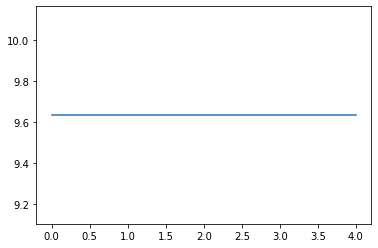

In [12]:
import matplotlib.pyplot as plt

BATCH_SIZE = 100
EPOCHS = 5
plot = []

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,3000).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)
        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y.long())
        
        loss.backward()
        optimizer.step()    # Does the update
    
    plot.append([epoch, float(loss)])
    print(f"\nEpoch: {epoch}. Loss: {loss}")

plot = list(map(list, zip(*plot)))
plt.plot(plot[0], plot[1])

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = test_y[i].to(device)
        net_out = net(test_X[i].view(-1,1,3000).to(device))[0]  # returns a list
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 194/194 [00:00<00:00, 412.57it/s]

Accuracy:  0.247
